## 1. Searching for gold inside HTML files
In this project, I'll try to make a <a href="https://en.wikipedia.org/wiki/Sentiment_analysis"> <b> Sentiment Analysis</b></a> on financial news headlines from <a href="https://finviz.com"><b>FINVIZ.com</b></a> through web scraping to know the emotion behind the headlines and predict if the market status is good or bad.</p>

<b>Why headlines? And why from FINVIZ?</b>
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. Consistent textual patterns will improve the sentiment analysis.</li>
</ol>
<p>As <a href="https://en.wikipedia.org/wiki/Web_scraping"> <b> web scraping</b></a> requires data science ethics (sending a lot of traffic to a FINVIZ's servers isn't very nice), the HTML files for Facebook and Tesla at various points in time have been downloaded. Let's import these files into memory.</p>

In [115]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

# Get the html file we need and make tables for particular class that contains important information
for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    table_file = open(table_path, "r")
    html = BeautifulSoup(table_file)
    html_table = html.find(id='news-table')
    html_tables[table_name] = html_table


## 2. What is inside those files anyway?
<p>Understanding what's inside those tables by exploring them to parse them well.

In [116]:
# Open one table and get all tr tags 
tsla = html_tables['tsla_22sep.html']
tsla_tr = tsla.findAll('tr') 

Difference between find_all and findAll in BeautifulSoup library,  <a href="https://stackoverflow.com/questions/12339323/difference-between-findall-and-find-all-in-beautifulsoup"><b>Check This</b></a> 

In [117]:
#<tr> determines each row in tsla table
# For each row, get all hyperlinks text from  anchor and each cell in HTML table
for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text()
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    print(link_text)
    print(data_text)
    # Avoiding spamming the notebook by taking first four loops
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extract the news headlines
<p>Trying to parse the data in a well formated structure

In [118]:
parsed_news = []

for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in each table
    for x in news_table.findAll('tr'):
        text = x.get_text()
        headline = x.a.get_text()
        # Split time into list with elements, if this element has only 1, wite it down, else write both elements 
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

In [119]:
#Check the structure 
parsed_news[0]

['fb',
 'Jan-04-19',
 '06:22PM',
 'Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains']

## 4. Use NLTK library
NLTK consists of the most common algorithms such as tokenizing, part-of-speech tagging, stemming, sentiment analysis, topic segmentation, and named entity recognition. NLTK helps the computer to analysis, preprocess, and understand the written text.

<b> Importing VADER: </b>( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.

In [120]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zas47\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [121]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Set values to each word
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

## 5. NLTK Crushes Sentiment Estimates
<p>Now we are trying to predict sentiment from news headlines. Notice that a real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>

In [122]:
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of (tables)lists that we just parsed into a DataFrame
scored_news = pd.DataFrame(parsed_news,columns=columns)
scored_news.head()

,ticker,date,time,headline
0,fb,Jan-04-19,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ..."
1,fb,Jan-04-19,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...
2,fb,Jan-04-19,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...
3,fb,Jan-04-19,04:53PM,3 Tech Trends to Watch in 2019
4,fb,Jan-04-19,04:30PM,Will Denver's tech growth continue in 2019?


According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment

In [123]:
# Get the polarity score for each headline
scores = []
for value in scored_news.headline.values:
    scores.append(vader.polarity_scores(value))

In [124]:
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news,scores_df],axis=1)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.0,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.0,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.0,0.698,0.302,0.3818


## 6. Plot all the sentiment in subplots
<p>Now Let's try plotting results

- Check cross section definition <a href="https://www.w3resource.com/pandas/series/series-xs.php#:~:text=The%20xs()%20function%20is,particular%20level%20of%20a%20MultiIndex.&text=Label%20contained%20in%20the%20index%2C%20or%20partially%20in%20a%20MultiIndex.&text=Axis%20to%20retrieve%20cross-section%20on." > here </a>

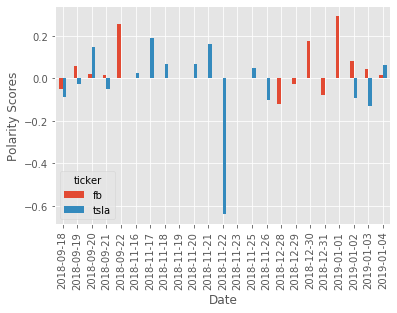

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date','ticker']).mean()
#Reshaping dataframe by unstacking
mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound 
mean_c = mean_c.xs('compound', axis=1)
mean_c.plot.bar();
plt.xlabel("Date");
plt.ylabel("Polarity Scores");

## 7. Cleaning Data
<p>Let's clean up our data

In [126]:
num_news_before = len(scored_news['headline'])
scored_news_clean = scored_news.drop_duplicates(['ticker','headline'])
num_news_after = len(scored_news_clean['headline'])
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

## 8. Sentiment on one single trading day and stock
Let's sentiment on 3 of Jan, 2019

In [127]:
scored_news_clean.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.0,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.0,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.0,0.698,0.302,0.3818


In [128]:
single_day = scored_news_clean.groupby(['ticker', 'date'])

In [129]:
single_day.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.000,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.000,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.000,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.000,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.000,0.698,0.302,0.3818
...,...,...,...,...,...,...,...,...
479,tsla,2018-11-16,06:50PM,Cramer's lightning round: Don't buy shares of ...,0.146,0.854,0.000,-0.2235
480,tsla,2018-11-16,04:27PM,Tesla has opened up Model 3 orders to customer...,0.000,1.000,0.000,0.0000
481,tsla,2018-11-16,04:20PM,David Einhorn's Top 4 Sells in 3rd Quarter,0.000,0.769,0.231,0.2023
482,tsla,2018-11-16,02:46PM,Tesla Ramps Up Its International Expansion for...,0.000,1.000,0.000,0.0000


In [130]:
single_day = scored_news_clean.set_index(['ticker', 'date'])
# gather facebook row and select 3rd Jan,2019
single_day = single_day.loc['fb']
single_day = single_day.loc['2019-01-03']
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time
# Sort it
single_day= single_day.set_index('time')

## 9. Visualize the single day
<p>We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock. This is just one of the many ways to visualize this dataset.</p>

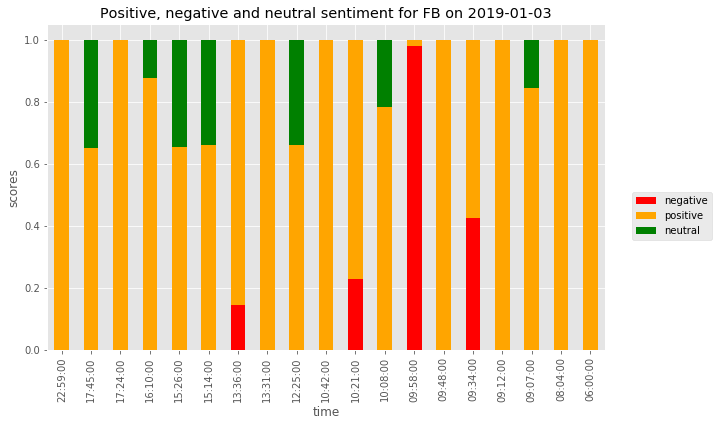

In [131]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");